# Final Project

Anubha Srivastava

# Analyzing a "Good" Workout

The goal of this project is to analyze and classify the distinction between a person's heart patterns after conducting intensive exercise versus simply walking. The data was collected in well-defined, controlled setting in a total period of 1:30 minutes, with the subject resting for one session, walking for the next session, and exercising for the last session . The data collected from the Empatica Band included Accelerometer, Heart Rate, Blood Volume Pressure, and Body Temperature data.

In order to provide a general benchmark of when a good workout has been achieived by a 115lb female, we must analyze the relative increases in acceleration, blood volume pressure, skin temperature, and hear rate data. Using this data, I attemped to identify the difference between varying levels of exertion. This methodology allowed for a lot of different methods for classification and analysis. The specific analysis steps are detailed below.


### Project Analysis Steps

1. PCA between Walking and Exercising Data 
2. Peak Detection between Walking and Exercising Steps
3. Gait Reconstruction for each data set

4. Whitening all the Temperature Data
5. Temperature Gradient Ascent Kurtosis Maximization

6. Pre-PCA on BVP for Walking and Exercising Data
7. Fisher LDA on BVP Data
8. LDA Bin-Classification using BVP Data
9. Heartrate Calculation and Reconstruction from BVP 
10. Heartrate K-Means Classification





In [1]:
#Load Libraries
#IPython is what you are using now to run the notebook
import IPython
print ("IPython version:      %6.6s (newest at 6.1.0)" % IPython.__version__)

# Numpy is a library for working with Arrays
import numpy as np
print ("Numpy version:        %6.6s (newest at 1.13.1)" % np.__version__)

# SciPy implements many different numerical algorithms
import scipy as sp
print ("SciPy version:        %6.6s (newest at 0.19.1)" % sp.__version__)

# Pandas makes working with data tables easier
import pandas as pd
print ("Pandas version:       %6.6s (newest at 0.20.3)" % pd.__version__)

# Module for plotting
import matplotlib
print ("Mapltolib version:    %6.6s (newest at 2.0.2)" % matplotlib.__version__)

# SciKit Learn implements several Machine Learning algorithms
import sklearn
print ("Scikit-Learn version: %6.6s (newest at 0.19.0)" % sklearn.__version__)

# MNE is a package for processing (EEG) and (MEG) data 
import mne
print ("MNE version:          %6.6s (newest at 0.14.1)" % mne.__version__)

IPython version:       6.1.0 (newest at 6.1.0)
Numpy version:        1.13.1 (newest at 1.13.1)
SciPy version:        0.19.1 (newest at 0.19.1)
Pandas version:       0.20.2 (newest at 0.20.3)
Mapltolib version:     2.0.2 (newest at 2.0.2)
Scikit-Learn version: 0.18.2 (newest at 0.19.0)
MNE version:          0.14.1 (newest at 0.14.1)


In [2]:
#Load Find Peaks
from copy import deepcopy
%matplotlib inline
import matplotlib.pyplot as plt
import peakutils
from peakutils.plot import plot as pplot

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
#Loading Data
#Accelerometer data for walking
walk = pd.read_csv("WalkACC.csv", delimiter = ",")


sit = pd.read_csv("SitACC.csv", delimiter = ",")


run = pd.read_csv("RunACC.csv", delimiter = ",")



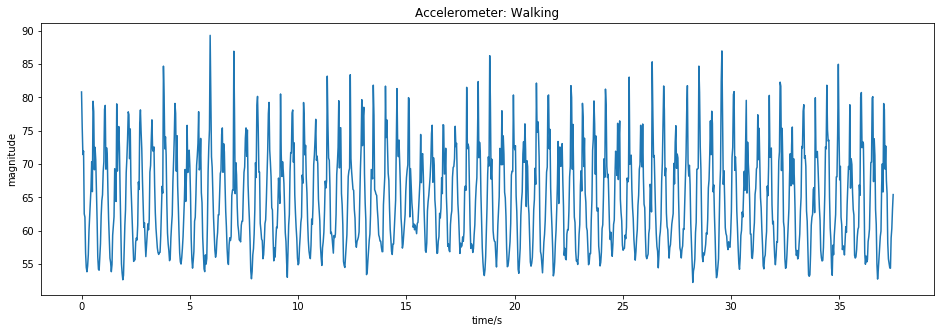

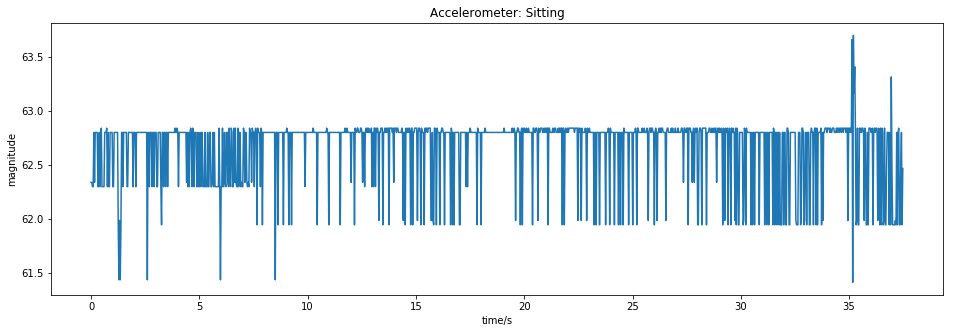

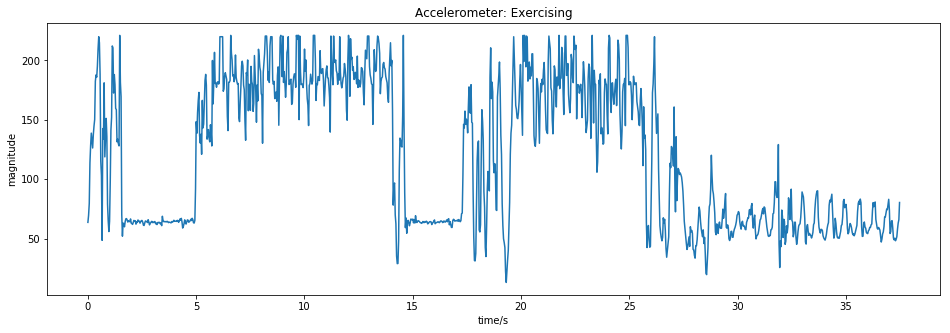

In [5]:
#Plot Walking Data
length = walk.shape[0] / 32 #here the sampling frequency is 32Hz
time_walk = np.linspace(0, length, walk.shape[0])

walk_acc = (np.sqrt((walk** 2).sum(axis = 1))).values
walk_acc = walk_acc[400:1600]
t_walk = time_walk[:1200]

fig = plt.figure(figsize=(16, 5))
plt.plot(t_walk, walk_acc)
plt.title("Accelerometer: Walking")
plt.xlabel("time/s")
plt.ylabel("magnitude")
plt.show()

#Plot Sitting Data
length = sit.shape[0] / 32 #here the sampling frequency is 32Hz
time_sit = np.linspace(0, length, sit.shape[0])

sit_acc = (np.sqrt((sit** 2).sum(axis = 1))).values
sit_acc = sit_acc[400:1600]
t_sit= time_sit[:1200]
 
fig = plt.figure(figsize=(16, 5))
plt.plot(t_sit, sit_acc)
plt.title("Accelerometer: Sitting")
plt.xlabel("time/s")
plt.ylabel("magnitude")
plt.show()

#Plot Running Data
length = run.shape[0] / 32 #here the sampling frequency is 32Hz
time_run = np.linspace(0, length, run.shape[0])

run_acc = (np.sqrt((run** 2).sum(axis = 1))).values
run_acc = run_acc[400:1600]
t_run= time_run[:1200]
 
fig = plt.figure(figsize=(16, 5))
plt.plot(t_run, run_acc)
plt.title("Accelerometer: Exercising")
plt.xlabel("time/s")
plt.ylabel("magnitude")
plt.show()

#Remove the mean from both data sets
walkmean = walk_acc.mean()
walk_acc_zero_mean = walk_acc - walkmean



sitmean = sit_acc.mean()
sit_acc_zero_mean = sit_acc - sitmean


runmean = run_acc.mean()
run_acc_zero_mean = run_acc - runmean




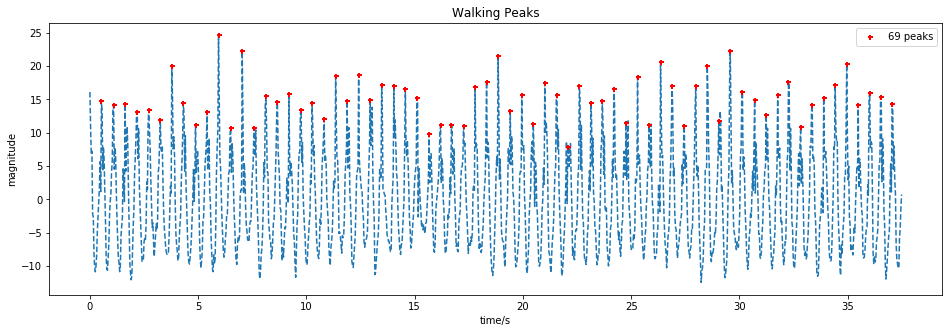

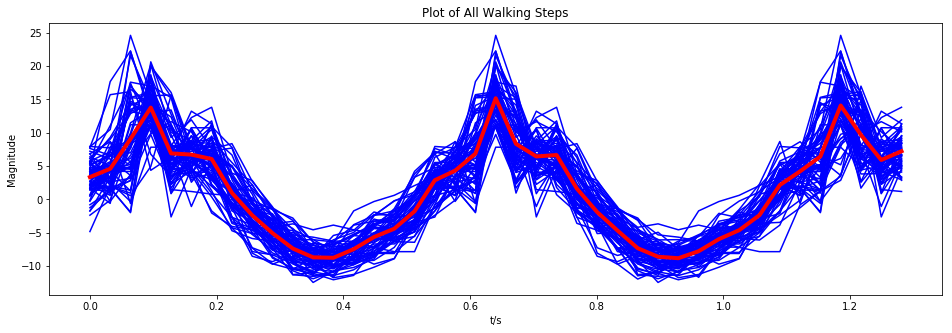

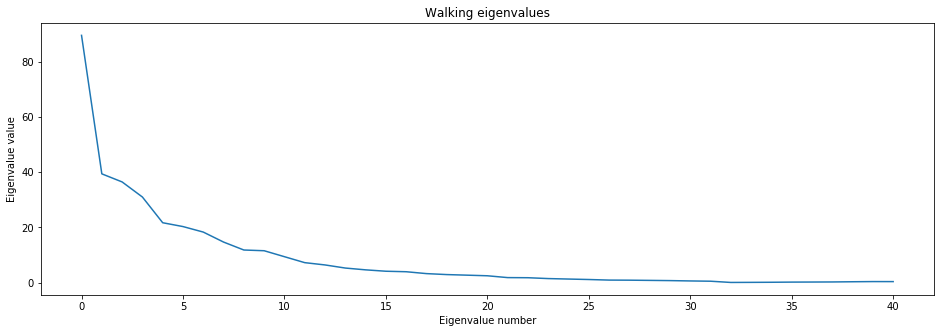

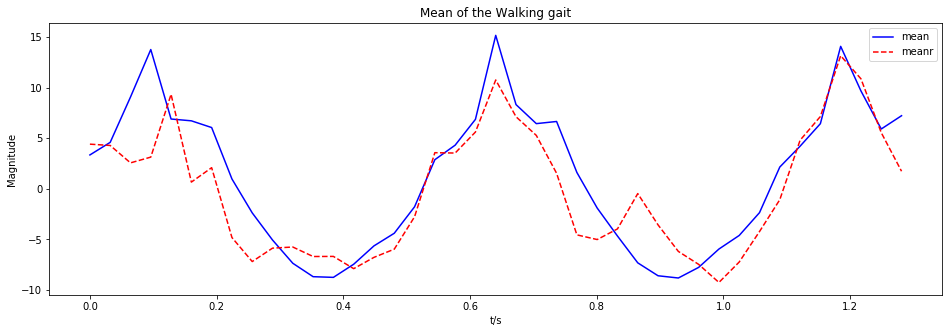

In [6]:
#Peakfinder on Walking Heartbeat

indexes = peakutils.indexes(walk_acc_zero_mean, thres=0.5, min_dist=15)  
plt.figure(figsize=(16,5))
pplot(t_walk, walk_acc_zero_mean, indexes)
plt.title('Walking Peaks')
plt.xlabel("time/s")
plt.ylabel("magnitude")
plt.show()

#Plot All Walking Steps 
indexes = indexes[1:-1] #remove the first and last indexes that may not give you 51 samples

#line up my steps
buffersize = 20
walksteps = np.zeros((len(indexes),41))
for i,index in enumerate(indexes):
    temp = np.arange(index-buffersize,index+buffersize+1)
    walksteps[i,:] = walk_acc_zero_mean[temp]   
  
    


 
walksteps = np.transpose(walksteps)
walk_mean_step = np.mean(walksteps, axis = 1)


t = np.linspace(0,41/32,41) #in time scale
plt.figure(figsize=(16,5))
plt.plot(t.reshape(-1,1), walksteps, color='b')
plt.plot(t.reshape(-1,1),walk_mean_step, color = 'r',linewidth = 4, label = "Mean Step")
plt.title("Plot of All Walking Steps")
plt.xlabel("t/s")
plt.ylabel("Magnitude")
plt.show()



#Calculate Walking PCA Matrix
#mu1 = np.repeat(walk_mean_step.reshape([-1,1]), 29 , axis=1)
#walksteps = walksteps - mu1
C = np.cov((walksteps)) #remove mean from all steps
D, U = np.linalg.eig(C)
plt.figure(figsize=(16,5))
plt.plot(np.real(D))
plt.xlabel('Eigenvalue number')
plt.ylabel('Eigenvalue value')
plt.title('Walking eigenvalues')
plt.show()


#Find minumum eigenvectors to recontruct my gaits
U = U.real
D = D.real

# get the first 10 eigenvectors
n = 10
W = U[:,:n].T

#construct all steps with the first 10 eigenvectors
Y = np.dot(W, walksteps)

# reconstructed data added back the mean 
walkstepsr = (W.T).dot(Y) 

#mean of reconstruction
walk_meanr_my = np.mean(walkstepsr, axis = 1)


plt.figure(figsize=(16,5))
plt.plot(t,walk_mean_step,color = "b",label = "mean")
plt.plot(t,walk_meanr_my,'r--',label = "meanr")
plt.title("Mean of the Walking gait")
plt.xlabel('t/s')
plt.ylabel('Magnitude')
plt.legend()
plt.show()



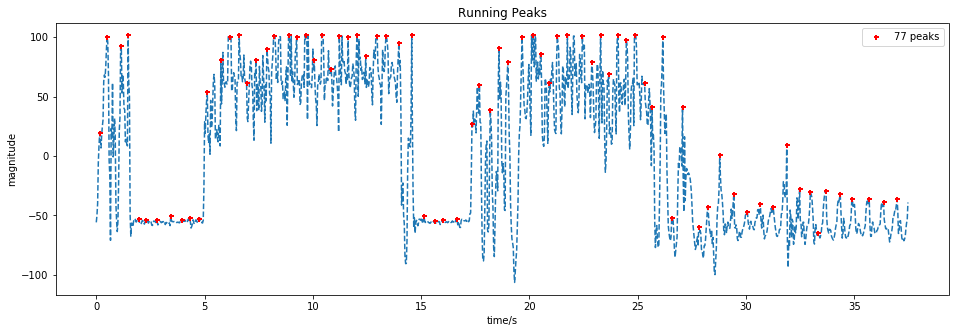

(75,)


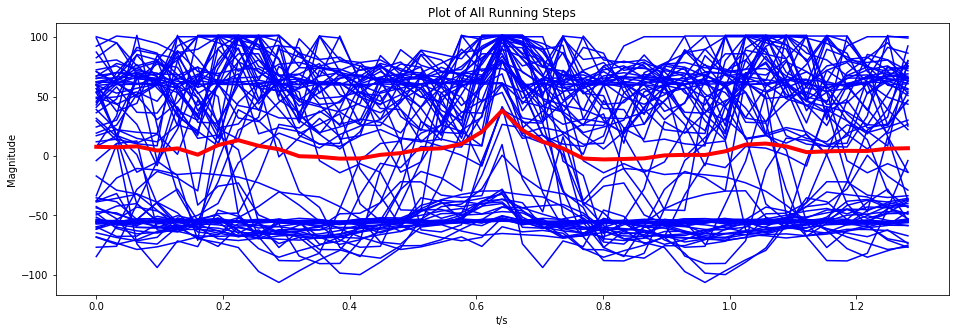

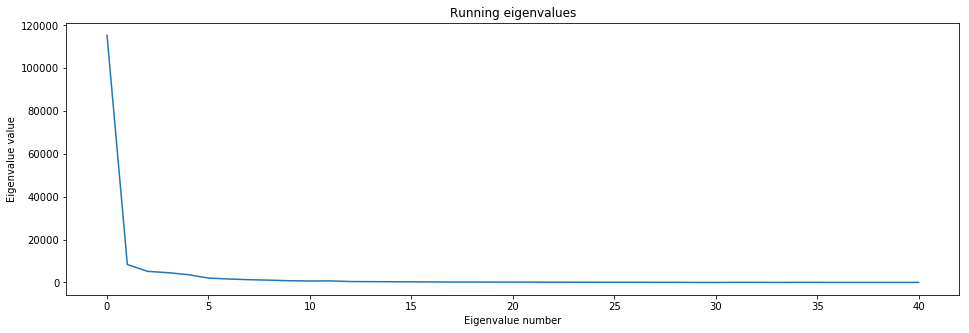

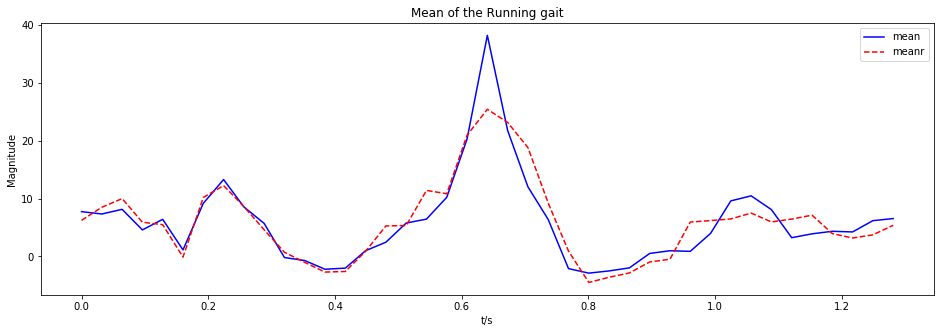

In [7]:
#Plotting Running Peaks


run_indexes = peakutils.indexes(run_acc_zero_mean, thres=0.1, min_dist=10)  
plt.figure(figsize=(16,5))
pplot(t_run, run_acc_zero_mean, run_indexes)
plt.title('Running Peaks')
plt.xlabel("time/s")
plt.ylabel("magnitude")
plt.show()

run_indexes = run_indexes[1:-1]

#remove the first and last indexes that may not give you 51 samples
#run_indexes= run_indexes[-1:1]
print(run_indexes.shape)



#line up my steps
buffersize = 20
runsteps = np.zeros((len(run_indexes),41))
for i,index in enumerate(run_indexes):
    temp_r = np.arange(index-buffersize,index+buffersize+1)
    runsteps[i,:] = run_acc_zero_mean[temp_r] 
    
    

runsteps= np.transpose(runsteps)
run_mean_step = np.mean(runsteps,axis = 1)



t_walk = np.linspace(0,41/32,41) #in time scale
plt.figure(figsize=(16,5))
plt.plot(t_walk.reshape(-1,1), runsteps, color='b')
plt.plot(t_walk.reshape(-1,1),run_mean_step, color = 'r',linewidth = 4, label = "Mean Step")
plt.title("Plot of All Running Steps")
plt.xlabel("t/s")
plt.ylabel("Magnitude")
plt.show()


#Calculate Walking PCA Matrix
#mu1 = np.repeat(walk_mean_step.reshape([-1,1]), 29 , axis=1)
#walksteps = walksteps - mu1
C = np.cov((runsteps)) #remove mean from all steps
D, U = np.linalg.eig(C)
plt.figure(figsize=(16,5))
plt.plot(np.real(D))
plt.xlabel('Eigenvalue number')
plt.ylabel('Eigenvalue value')
plt.title('Running eigenvalues')
plt.show()


#Find minumum eigenvectors to recontruct my gaits
U = U.real
D = D.real

# get the first 10 eigenvectors
n = 10
W = U[:,:n].T

#construct all steps with the first 10 eigenvectors
Y = np.dot(W, runsteps)

# reconstructed data added back the mean 
runstepsr = (W.T).dot(Y) 

#mean of reconstruction
run_meanr_my = np.mean(runstepsr, axis = 1)


plt.figure(figsize=(16,5))
plt.plot(t,run_mean_step,color = "b",label = "mean")
plt.plot(t,run_meanr_my,'r--',label = "meanr")
plt.title("Mean of the Running gait")
plt.xlabel('t/s')
plt.ylabel('Magnitude')
plt.legend()
plt.show()



Here we can see that the walking data and the exercising data yielded different gaits. While the walking data showed more consistancy in acceleration, the exercising data showed a lot more variability. This is to be expected, as the rate as someone exercises is subject to a lot more fluctations in motion than someone who is steadily walking. The resting data is only graphed, not analyzed, because the minimum acceleration yielded by sitting in one place would lead to a negligable gait. Finally, we can see that the eigenvalues presented are on the magntiude of 10^3 higher for exercising data than they are for walking data. This shows that there is a drastic difference between walking and exercising in terms of acceleration. Again, this was to be expected.

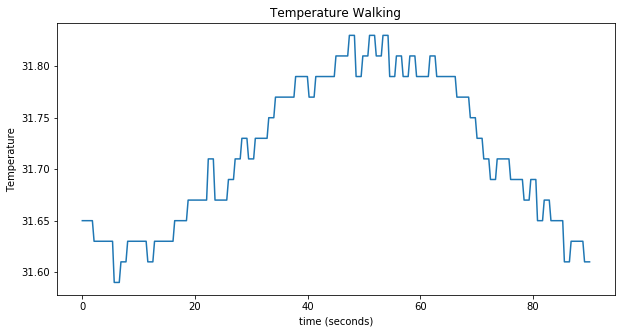

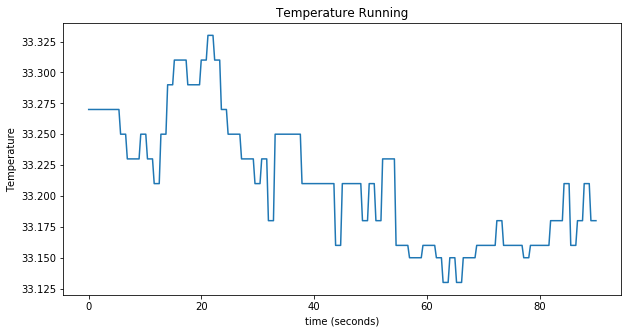

In [8]:
#PCA clustering between exercising and temperature
temp_run = pd.read_csv("TEMPrun.csv", delimiter = ",", skiprows= 2)
temp_run= temp_run[0:303]


temp_walk = pd.read_csv("TEMPwalk.csv", delimiter = ",", skiprows= 2)



#Plot temperatures 
time= np.linspace(0, 90, 303)
fig = plt.figure(figsize=(10, 5))
plt.plot(time, temp_walk)
plt.title("Temperature Walking")
plt.xlabel("time (seconds)")
plt.ylabel("Temperature")
plt.show()


fig = plt.figure(figsize=(10, 5))
plt.plot(time, temp_run)
plt.title("Temperature Running")
plt.xlabel("time (seconds)")
plt.ylabel("Temperature")
plt.show()


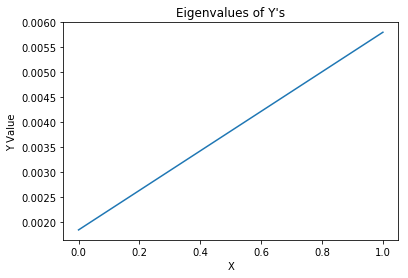

In [9]:
#Gradient Ascent Kurtosis Maximization
temp_run= temp_run

y= np.column_stack((temp_run, temp_walk))
y=y.T


y1_mean= np.mean(temp_walk)
y2_mean= np.mean(temp_run)


mu1 = np.repeat(y1_mean.values.reshape([-1,1]), 303, axis=1)
mu2 = np.repeat(y2_mean.values.reshape([-1,1]), 303, axis=1)


mean= np.row_stack((mu1, mu2))
y_actual= y - mean

C = np.cov(y_actual)
D, U = np.linalg.eig(C)

plt.plot(np.real(D))
plt.title("Eigenvalues of Y's")
plt.xlabel("X")
plt.ylabel("Y Value")
plt.show()

#Whiten the Data
#Z=WT(X−X_mean)
#covar(Z)=I2×2


W = U
m= np.dot(W.T,y_actual)
l= [0.00185054, 0]
p= [0, 0.00579399]

V= np.row_stack((l,p))
V=sp.linalg.fractional_matrix_power (V, -1/2)
Z= np.dot(V, m)
I= np.cov(Z)


#Kurtosis descent 
#w = sgn(kurt(wT z))E[(wT*z)^3z]

a= np.dot(W.T, Z)


#Expectation portion, ignore the sign 
b= np.power(a, 3)
c= np.dot(Z, b.T)
deltaWk= np.mean(c)

n=.5
for n in range(50):
    vk = W + n*deltaWk
    mag= np.sqrt(np.square(vk[0])+ np.square(vk[1]))
    magvk= mag**2
    wk= vk/magvk
    wk= wk[1]
    
    
def null(A, rtol=1e-5):
    '''
    Computes an orthonormal basis for the null space of A obtained from the singular value decomposition. 
    A - input matrix or vector
    rtol - tolarence value
    returns an orthonormal basis for the null space of A
    '''
    if len(A.shape) < 2:
        A = np.vstack([A, np.zeros(A.shape)])
        
    u, s, v = np.linalg.svd(A)
    rank = (s > rtol*s[0]).sum()
    return v[rank:].T

#Display temp
b= wk
O= null(b, 1)

signal= np.dot(O, y)
time= np.linspace(0, 90, 303)



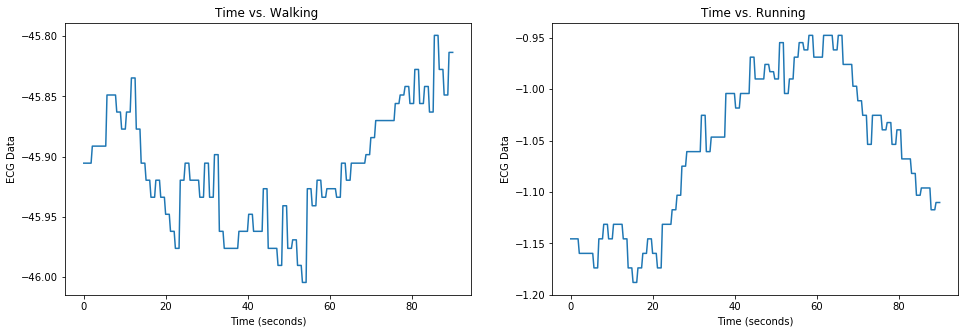

In [10]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(time,  signal[0].T)
plt.title("Time vs. Walking ")
plt.xlabel("Time (seconds)")
plt.ylabel("ECG Data")

plt.subplot(1, 2, 2)
plt.plot(time,  signal[1].T)
plt.title("Time vs. Running ")
plt.xlabel("Time (seconds)")
plt.ylabel("ECG Data")
plt.show()



From the original graphs, we can see that temperature associated with walking gradually increases as time increases, a direct result of the body's exertion level rising. However, this temperautre does not compare to that of the exercising session. In the exercise session, the temparature is a full two or three degrees higher at all points. Interestingly, we can see the temparture actually decreases througout the course fo the exercising session. This is a direct result of the body releasing fluids (sweating) in order to decreases internal body temperatures. As we sweat, the temparature of our skin actually decreases slightly. The ICA technique done here works due to the fact that I am comparing two different sets of temperature data, one as a result of walking and one as a result of running. We can see that the source signals are independent of each other. Using Kurtosis Ascent Maximization, I minimized the collection of mutual information between the original data sets in order to determine if there was any original correlations. As we can see, the two data sets are very independent of each other.

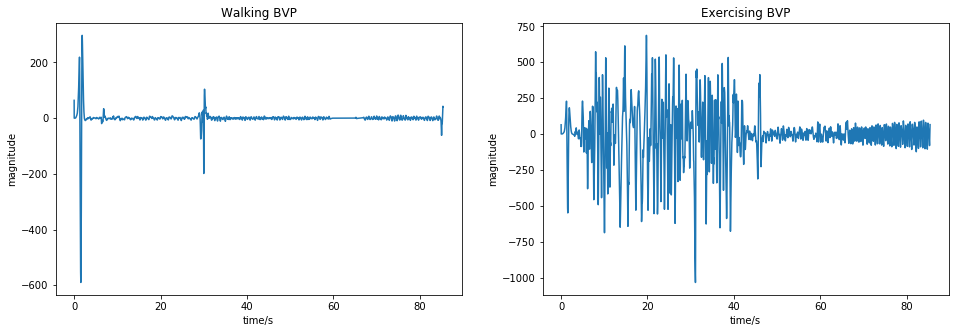

(5468, 1)
(5468, 1)


In [11]:
#Hearate produced while walking
bvp_walk = pd.read_csv("BVP.csv", delimiter = ",")


l = bvp_walk.shape[0] / 64 #here the sampling frequency is 32Hz
x = np.linspace(0, l, bvp_walk.shape[0])

plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(x, bvp_walk)
plt.title("Walking BVP")
plt.xlabel("time/s")
plt.ylabel("magnitude")


#Heartrate produced by running
bvp_run = pd.read_csv("RunBVP.csv", delimiter = ",")
bvp_run = bvp_run[0:5468]

plt.subplot(1, 2, 2)
plt.plot(x, bvp_run)
plt.title("Exercising BVP")
plt.xlabel("time/s")
plt.ylabel("magnitude")
plt.show()

print(bvp_run.shape)
print(bvp_walk.shape)



Number of hearbeats:  142


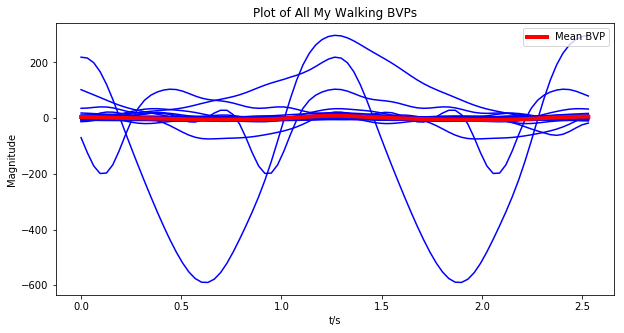

Number of hearbeats:  149


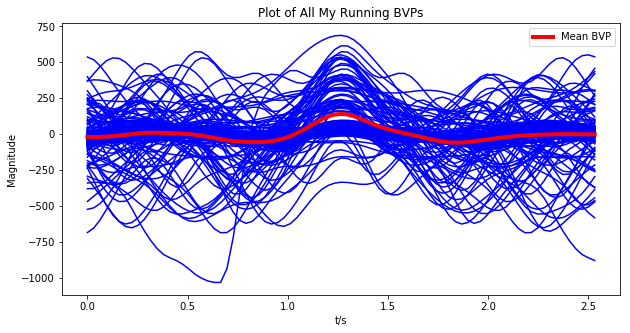

In [12]:
bvp_run= np.squeeze(bvp_run, axis=1)
bvp_walk= np.squeeze(bvp_walk, axis=1)
#WALKING BVP
#use middle data
#bvp_walk = bvp_walk[1800:4000]
#convert bvp to heartrate 
#calculate the mean
bvp_walk_mean = bvp_walk.mean()
#subatract the data with mean
walk_bvp_zero_mean = bvp_walk - bvp_walk_mean


w_indexes = peakutils.indexes(walk_bvp_zero_mean, thres=0.4, min_dist=20)

w_indexes = w_indexes[1:-1]

#line up the heartbeats
buffersize = 40
walk_bvps = np.zeros((len(w_indexes),81))
for i,index in enumerate(w_indexes):
    temp = np.arange(index-buffersize,index+buffersize+1)
    walk_bvps[i,:] = walk_bvp_zero_mean[temp]
        

walk_bvps = np.transpose(walk_bvps)
print ("Number of hearbeats: ", walk_bvps.shape[1])

t = np.linspace(0,81/32,81)
walk_mean_bvp = np.mean(walk_bvps,axis = 1)
plt.figure(figsize=(10,5))
plt.plot(t.reshape(-1,1),walk_bvps,color = 'b')
plt.plot(t.reshape(-1,1),walk_mean_bvp,color = 'r',linewidth = 4, label = "Mean BVP")
plt.title("Plot of All My Walking BVPs")
plt.xlabel("t/s")
plt.ylabel("Magnitude")
plt.legend()
plt.legend(loc='upper right');
plt.show()

#bvp_run = bvp_run[1800:4000]
#calculate the mean
bvp_run_mean = bvp_run.mean()
#subatract the data with mean
run_bvp_zero_mean = bvp_run - bvp_run_mean

r_indexes = peakutils.indexes(run_bvp_zero_mean, thres=0.4, min_dist=20)

r_indexes = r_indexes[1:-1]

#line up the heartbeats
buffersize = 40
run_bvps = np.zeros((len(r_indexes),81))
for i,index in enumerate(r_indexes):
    temp = np.arange(index-buffersize,index+buffersize+1)
    run_bvps[i,:] = run_bvp_zero_mean[temp]

run_bvps = np.transpose(run_bvps)
print ("Number of hearbeats: ", run_bvps.shape[1])

t = np.linspace(0,81/32,81)
run_mean_bvp = np.mean(run_bvps,axis = 1)
plt.figure(figsize=(10,5))
plt.plot(t.reshape(-1,1),run_bvps,color = 'b')
plt.plot(t.reshape(-1,1),run_mean_bvp,color = 'r',linewidth = 4, label = "Mean BVP")
plt.title("Plot of All My Running BVPs")
plt.xlabel("t/s")
plt.ylabel("Magnitude")
plt.legend(loc= "upper right")
plt.show()





Here we can see clearly see a quantitative difference between the BVP produced during the walking session and the exercising session. We see that BVP's during the exercising stage are not only larger in magnitude, but more frequently occuring during the allocated time span. The exercising BVP's have a magnitude of approximately 1300, meanwhile the walking BVP's have a magnitude of approcximately 6050. This is nearly a two times increase in blood volume pressure once the exercising is at its peak.

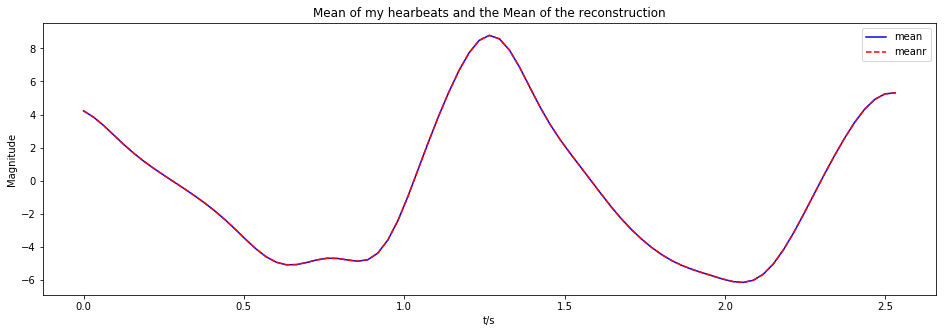

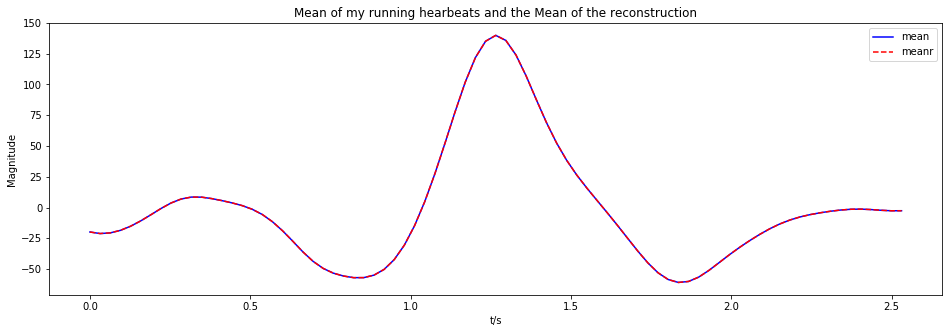

In [13]:
#calculate walking PCA matrix
w_mu = np.repeat(walk_mean_bvp.reshape([-1,1]), 142, axis=1)
walk_bvps = walk_bvps - w_mu #remove the mean of hearbeats
w_C = np.cov((walk_bvps))
D, U = np.linalg.eig(w_C)

#find minumum eigenvectors to recontruct my gaits
U = U.real
D = D.real

# get the first 10 eigenvectors
n = 10
W = U[:,:n].T

# reconstruction
w_Y = np.dot(W, walk_bvps)

# reconstructed data with mean
walk_bvpsr = (W.T).dot(w_Y) + w_mu

walk_meanr = np.mean(walk_bvpsr,axis = 1)
plt.figure(figsize=(16,5))
plt.plot(t,walk_mean_bvp,color = "b",label = "mean")
plt.plot(t,walk_meanr,'r--',label = "meanr")
plt.title("Mean of my hearbeats and the Mean of the reconstruction")
plt.xlabel('t/s')
plt.ylabel('Magnitude')
plt.legend()
plt.show()


#calculate walking running matrix
r_mu = np.repeat(run_mean_bvp.reshape([-1,1]), 149, axis=1)
run_bvps = run_bvps - r_mu #remove the mean of hearbeats
r_C = np.cov((run_bvps))
D, U = np.linalg.eig(r_C)

#find minumum eigenvectors to recontruct my gaits
U = U.real
D = D.real

# get the first 10 eigenvectors
n = 10
W = U[:,:n].T

# reconstruction
r_Y = np.dot(W, run_bvps)

# reconstructed data with mean
run_bvpsr = (W.T).dot(r_Y) + r_mu

run_meanr = np.mean(run_bvpsr,axis = 1)
plt.figure(figsize=(16,5))
plt.plot(t,run_mean_bvp,color = "b",label = "mean")
plt.plot(t,run_meanr,'r--',label = "meanr")
plt.title("Mean of my running hearbeats and the Mean of the reconstruction")
plt.xlabel('t/s')
plt.ylabel('Magnitude')
plt.legend()
plt.show()




In addition to the visible difference between BVP, I reconstructed the heart rates so we can have closer look at the quantitative difference between walking heart rate and exercising heart rate. Here we can see that the average heart rate amplitude for the walking session is 14. Meanwhile, the average heart rate for the exercising session is 200. This is a massive, quantifiable difference between a leasiurely stroll and an intense workout. In the case of a defining a good workkout, it seems like it would require an approximate 10 time increase in heartrate amplitude.

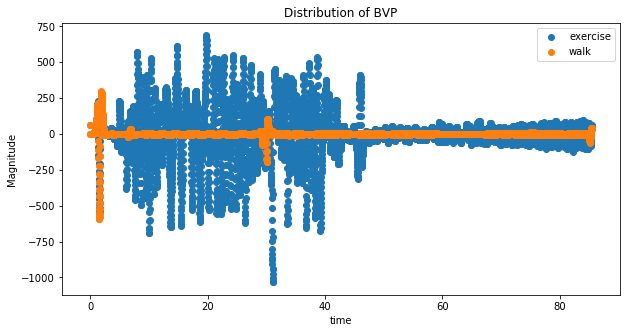

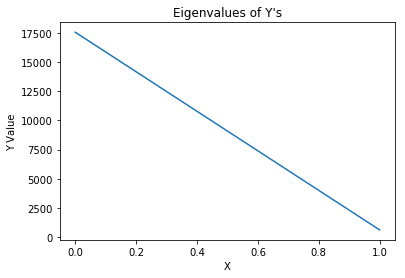

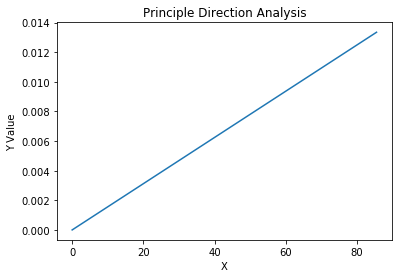

[  3.29969290e-09   2.18765527e-05]


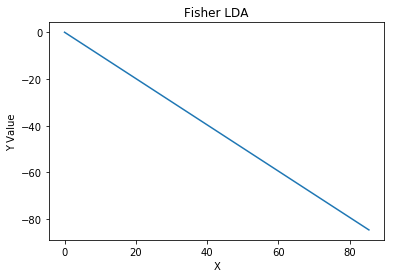

In [14]:
#LDA
plt.figure(figsize=(10,5))
plt.scatter(x, bvp_run,  label= 'exercise')
plt.scatter(x, bvp_walk,  label= 'walk')
plt.title("Distribution of BVP")
plt.xlabel("time")
plt.ylabel("Magnitude")
plt.legend(loc='upper right');
plt.show()
stacky1= np.column_stack((bvp_run, x))
stacky2= np.column_stack((bvp_walk, x))


y= np.row_stack((stacky1, stacky2))


mean_y= np.mean(y)
#mu = np.repeat(mean_y.reshape([-1,1]), 42, axis=1)
C = np.cov(y.T)
D, U = np.linalg.eig(C)

plt.plot(np.real(D))
plt.title("Eigenvalues of Y's")
plt.xlabel("X")
plt.ylabel("Y Value")
plt.show()



slope_x= 1.56243178e-04
slope_y= 9.99999988e-01
#Principle Direction
plt.plot(x, x*slope_x/slope_y)
plt.title("Principle Direction Analysis")
plt.xlabel("X")
plt.ylabel("Y Value")
plt.show()

#Fisher
#Calculate Fisher

#Mean between classes
y_mean= np.mean(bvp_run)- np.mean(bvp_walk)

Mean=np.zeros(2)
Mean[0]= 0
Mean[1]= y_mean


#Covariance within each classes
stacky1= np.column_stack((bvp_run, x))
stacky2= np.column_stack((bvp_walk, x))
C = np.cov(stacky1.T)+ np.cov(stacky2.T)


#Find W, proportional to M^-1*C
C_inverse= np.linalg.inv(C)
W= np.dot(C_inverse, Mean)

print(W)

#Plot W
plt.plot(x, x*(-1.02/1.03))
plt.title("Fisher LDA")
plt.xlabel("X")
plt.ylabel("Y Value")
plt.show()



This Fisher LDA is chosen from analysis of the BVP's between exercising and walking. This LDA analysis models the difference between the classes of data represented above. In other words, we can see that there is a large quanitifiable differenc ebetween these two classes. 

[  8.50814738e-03  -1.97242228e+02]


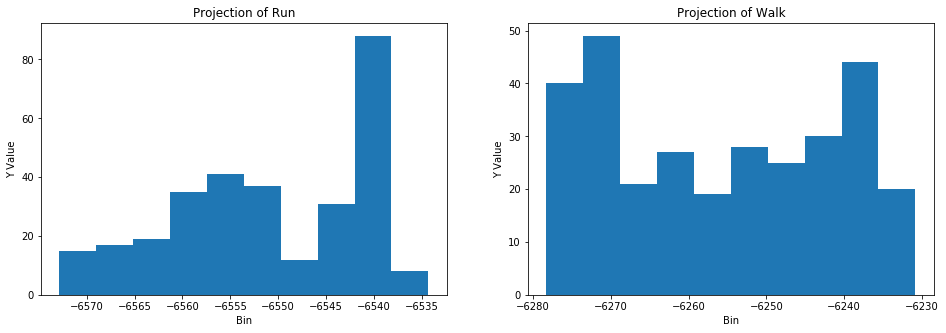

In [15]:
#Within-category means of running
bvp_run= bvp_run[:303]
temp_run= np.squeeze(temp_run, axis=0)

bvp_walk= bvp_walk[:303]
temp_walk= np.squeeze(temp_walk, axis=0)


runmatrix= np.column_stack((bvp_run, temp_run))
walkmatrix= np.column_stack((bvp_walk, temp_walk))

#Within-category means
mean_walk= np.mean(runmatrix, axis=0)
mean_run= np.mean(walkmatrix, axis=0)
Mean= mean_run- mean_walk


#Within-category covariances
C_T = np.cov(runmatrix.T)+ np.cov(walkmatrix.T)

#Find W, the Fisher Projection
C_inverset= np.linalg.inv(C_T)
W= np.dot(C_inverset, Mean)

print(W)


#Project and plot the data
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
Proj_run= np.dot(runmatrix, W)
plt.hist(Proj_run, bins=10)
plt.title("Projection of Run")
plt.xlabel("Bin")
plt.ylabel("Y Value")


plt.subplot(1, 2, 2)
Proj_walk= np.dot(walkmatrix, W)
plt.hist(Proj_walk, bins='auto')
plt.title("Projection of Walk")
plt.xlabel("Bin")
plt.ylabel("Y Value")
plt.show()





As seen from the LDA Bin Classification conducted above, the variable BVP and the variable temperatures are very different between the walking and the exercising data. In this way, we can quanitifibale say that the two data sets are different in the extents displayed above.

[[   7.  594.]
 [ 245.  389.]]


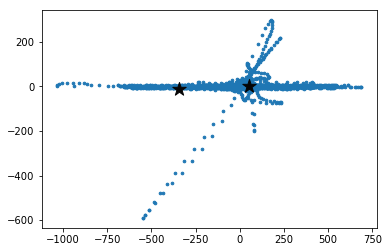

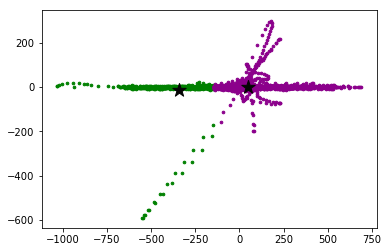

In [16]:
bvp_run = pd.read_csv("RunBVP.csv", delimiter = ",")
bvp_run = bvp_run[0:5468]

bvp_walk = pd.read_csv("BVP.csv", delimiter = ",")

bvp_run= np.squeeze(bvp_run, axis=1)
bvp_walk= np.squeeze(bvp_walk, axis=1)


def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)
data = np.array(list(zip(bvp_run, bvp_walk)))
k = 2
N_x = np.random.randint(0, np.max(data)-20, size=k)

N_y = np.random.randint(0, np.max(data)-20, size=k)
N = np.array(list(zip(N_x, N_y)), dtype=np.float32)
print(N)

from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

# Number of clusters
kmeans = KMeans(n_clusters=2)
# Fitting the input data
kmeans = kmeans.fit(data)
# Getting the cluster labels
labels = kmeans.predict(data)
# Centroid values
centroids = kmeans.cluster_centers_


plt.scatter(bvp_run, bvp_walk, s=7)
plt.scatter(centroids[:,0], centroids[:,1], marker='*', s=200, c='#050505')
plt.show()


# To store the value of centroids when it updates
centroid = np.zeros(N.shape)
# Cluster Lables(0, 1, 2)
clusters = np.zeros(len(data))
# Error func. - Distance between new centroids and old centroids
error = dist(N, centroid, None)

# Loop will run till the error becomes zero
while error != 0:
    # Assigning each value to its closest cluster
    for i in range(len(data)):
        distances = dist(data[i], N)
        cluster = np.argmin(distances)
        clusters[i] = cluster
    # Storing the old centroid values
    centroid = deepcopy(N)
    # Finding the new centroids by taking the average value
    for i in range(k):
        points = [data[j] for j in range(len(data)) if clusters[j] == i]
        N[i] = np.mean(points, axis=0)
    error = dist(N, centroid, None)
    
colors = ['g', 'darkmagenta']
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([data[j] for j in range(len(data)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
ax.scatter(N[:, 0], N[:, 1], marker='*', s=200, c='#050505')

This K-means clustering algorithm partitions 2 observations into 2 clusters in which each observation belongs to the cluster with the nearest mean. In other words, I aimed to cluster walking BVP Data and Exercising BVP data into two different catagories. Here, the purple dots represent the walking data. Meanwhile, the green dots represent the running data. We can see a cleare distinction between the two categories asides from a little bit of overlap. This overlap is a result of similar heart volume patterns during the beginning of the workout and the walking data (as it took some time for the workout to get the heart pumping faster, and the process was not instantanous). Overall, quantifiably, we can cluster these two data sets a way that distinguishes the exercise pattern and the walking pattern from each other. 

# What does a "Good" workout mean?

A good workout can mean different things to different people. However, to provide a genral benchmark of when a good workout has been achieived by a 115lb female, we must analyze the relative increases in acceleration, blood volume pressure, skin temperature, and hear rate data. In terms of acceleration, we can expect a highly variable gait for exercising as oppsoed to simply walking. More specifically, we can see that the eigenvalues presented by the exercising data are on the magntiude of 10^3 higher for excersing data than they are for walking data. In terms of skin temperature, the temparature of our skin actually decreases slightly once we are perfoming an intensive workout (however never dipping below the absolute magnitude of temperature generated by walking). Quantitatively,  there was no  collection of mutual information between the original temperature data sets. This implies that while skin temperature overall is higher during exercise, sweating causes there to be no linear correlation between how much skin temparature increases as a result of exertion. In addition, after reconstructing the heartrate from BVP's, we can see that that a good workout results in a higher than 10 times increase in heart rate magnitude (peak to peak) with respect to walking. Finally, in terms of classifying the two different data sets, we can use a k-means clustering algorithm to determine visually how a walking heart rate differs from a running heart rate.

# Concluding Thoughts

The purpose of this project was to use Accelerometer, BVP, temperature, and Heart Rate data to identify the difference between varying levels of exertion, ultimately deciding on what would be considered a "good" workout. For future research, I would like to incorporate data from multiple individuals in order to classify and quanitify a difference between a "good" workout for males with respect to females, people of different ages, and finally, people of different body types. In order to widen the scope of this project, I would also like to include data on breathing patterns and breathing control. The implications fo this project include developing a more concise and accurate fitness routine specified to each individual. 
 